# Introducción

En este trabajo práctico se utiliza el dataset público GAVADE con información de medicamentos, precios de referencia (PVP PAMI), coberturas y el importe abonado por los afiliados.
El objetivo es recorrer el ciclo completo de datos: obtención, limpieza, carga en base de datos SQLite y SQL Server y análisis exploratorio mediante un dashboard con gráficos interactivos.

**Paso 1 – Carga de datos**

Se sube el archivo en formato Excel, se normalizan los nombres de columnas y se limpian los campos monetarios para que puedan analizarse como números enteros.

In [17]:

# 1. Librerías necesarias

!pip install -q plotly openpyxl sqlalchemy statsmodels

import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files
import io
from IPython.display import display, Markdown

In [18]:

# 2. Subir archivo

uploaded = files.upload()

# Lee automáticamente el archivo
for fname, content in uploaded.items():
    if fname.lower().endswith(('.xls', '.xlsx')):
        df_gavade = pd.read_excel(io.BytesIO(content))
    elif fname.lower().endswith('.csv'):
        df_gavade = pd.read_csv(io.StringIO(content.decode('utf-8')))
    else:
        raise ValueError("Formato no soportado. Subí Excel o CSV.")

print("Columnas originales:", df_gavade.columns.tolist())

Saving gavade_20251001_091834.xlsx to gavade_20251001_091834 (1).xlsx
Columnas originales: ['ALFABETA', 'PRINCIPIO ACTIVO', 'MARCA COMERCIAL', 'PRESENTACION', 'LABORATORIO', 'PVP PAMI AL 01/10/2025', 'COBERTURA', 'IMPORTE AFILIADO']


In [19]:

# 3. Normalización de columnas

df_gavade.columns = df_gavade.columns.str.strip().str.lower().str.replace(" ", "_")

# Renombrar PVP con fecha a un nombre más manejable
if "pvp_pami_al_01/10/2025" in df_gavade.columns:
    df_gavade = df_gavade.rename(columns={"pvp_pami_al_01/10/2025": "pvp_pami"})

In [20]:

# 4. Limpieza de valores numéricos

def clean_money(col):
    return (
        col.astype(str)
        .str.replace(r'[^\d\.-]', '', regex=True)
        .replace('', '0')
        .astype(float)
        .astype(int)   # solo parte entera
    )

num_cols = [c for c in df_gavade.columns if "importe" in c or "pvp" in c]
for c in num_cols:
    df_gavade[c] = clean_money(df_gavade[c])

print("Preview limpio:")
display(df_gavade[num_cols].head())

Preview limpio:


,pvp_pami,importe_afiliado
0,16388,8194
1,22746,11373
2,12723,6361
3,55679,22271
4,37125,14850


**Paso 2 – Almacenamiento en base de datos**

Los datos son guardados en una base SQLite (medicamentos.db) y SQL Server, lo que permite luego ejecutar consultas SQL y mantener trazabilidad en el proceso.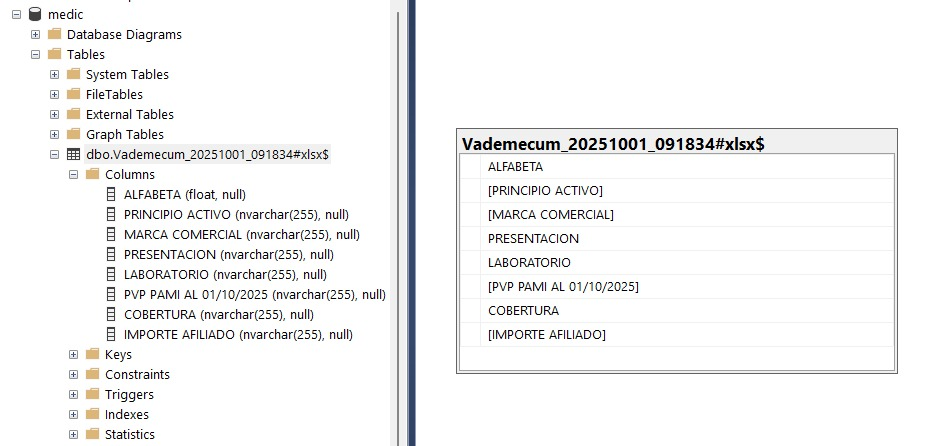

In [21]:

# 5. Guardar en SQLite

conn = sqlite3.connect("medicamentos.db")
df_gavade.to_sql("gavade", conn, if_exists="replace", index=False)
files.download("medicamentos.db")
print("Tabla 'gavade' creada en SQLite")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tabla 'gavade' creada en SQLite


**Paso 3 – Dashboard de indicadores**

Se construye un tablero con indicadores clave:

💰 Ahorro promedio real.

💵 Importe promedio abonado.

🏷️ Precio de referencia promedio.

📦 Cantidad total de productos.

In [36]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number", value=ahorro_prom,
    title={"text": "💰 Ahorro promedio real"},
    number={"prefix":"$","valueformat":",.0f","font":{"size":36}},
    domain={'row': 0, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number", value=prom_importe,
    title={"text": "💵 Importe promedio abonado"},
    number={"prefix":"$","valueformat":",.0f","font":{"size":36}},
    domain={'row': 0, 'column': 1}
))

fig.add_trace(go.Indicator(
    mode="number", value=prom_pvp,
    title={"text": "🏷️ Precio referencia promedio"},
    number={"prefix":"$","valueformat":",.0f","font":{"size":36}},
    domain={'row': 1, 'column': 0}
))

fig.add_trace(go.Indicator(
    mode="number", value=cant_productos,
    title={"text": "📦 Total de productos"},
    number={"valueformat":",d","font":{"size":36}},
    domain={'row': 1, 'column': 1}
))

fig.update_layout(
    title={"text": "📊 KPIs", "x":0.5, "xanchor":"center", "font":{"size":30}},
    grid={'rows': 2, 'columns': 2, 'pattern': "independent"},
    template="plotly_white",
    height=600
)

fig.show()


**KPIs generales**

El ahorro promedio real es de $15.788, lo que refleja un fuerte impacto del beneficio para los afiliados.

El importe promedio abonado es de $11.991, mostrando que en la práctica los afiliados pagan montos bastante menores al precio de referencia.

El precio de referencia promedio (PVP PAMI) es de $27.778, lo que significa que, sin cobertura, los costos serían más del doble.

El total de productos analizados es 8.023, lo que asegura robustez estadística.

**Paso 4 – Análisis exploratorio**

Se generan distintas visualizaciones:

📊 Histograma de importes abonados: permite observar la distribución y concentración en valores bajos.

🔵 Dispersión PVP PAMI vs Importe abonado: confirma la relación positiva entre precio de referencia y el gasto real del afiliado.

🥧 Distribución por rangos de precio: segmenta en categorías (“muy barato”, “barato”, “medio”, etc.) mostrando que la mayoría de los medicamentos se concentra en valores bajos.

In [23]:

# 7. Visualizaciones extra

# Distribución precios
fig1 = px.histogram(df_gavade, x="importe_afiliado", nbins=50,
                    title="Distribución de importes abonados")
fig1.show()

# Comparación PVP vs Importe
fig2 = px.scatter(df_gavade, x="pvp_pami", y="importe_afiliado",
                  title="Relación PVP PAMI vs Importe abonado",
                  trendline="ols")
fig2.show()


# Crear categorías de precios
df_gavade["rango_precio"] = pd.cut(df_gavade["importe_afiliado"],
                                   bins=[0, 5000, 20000, 50000, 100000, df_gavade["importe_afiliado"].max()],
                                   labels=["Muy barato (<5k)", "Barato (5k-20k)", "Medio (20k-50k)", "Caro (50k-100k)", "Muy caro (>100k)"])



# Por rangos de precio
df_rangos = df_gavade.groupby("rango_precio", observed=True).size().reset_index(name="cantidad")

fig_rangos = px.pie(df_rangos, names="rango_precio", values="cantidad",
                    title="Distribución de importes abonados por rango")
fig_rangos.show()



**Distribución de importes abonados**

La gran mayoría de los importes abonados se concentran en montos menores a $50.000.

Existe una cola larga de valores atípicos que llegan hasta los $350.000, pero son casos poco frecuentes.

Esto muestra que, aunque hay medicamentos de alto costo, la distribución es fuertemente sesgada hacia productos de bajo valor.

**Relación PVP PAMI vs Importe abonado**

La relación es prácticamente lineal: a mayor precio de referencia, mayor importe abonado.

Sin embargo, hay puntos dispersos que representan productos caros pero con un importe abonado bajo → probablemente medicamentos con mayor cobertura.

Esto sugiere que la cobertura no es uniforme: en algunos casos de medicamentos muy caros, el afiliado termina pagando muy poco.

**Distribución por rangos de precio**

49,8% de los productos están en el rango Barato (5k–20k).

33,4% son Muy baratos (<5k), lo cual explica por qué el importe promedio abonado es relativamente bajo.

13,7% se encuentran en el rango Medio (20k–50k).

Solo 2,5% en el rango Caro (50k–100k).

Apenas 0,6% son Muy caros (>100k).

Conclusión: el 83% de los medicamentos se concentran en rangos de bajo precio, y los productos de alto costo son marginales.

**Conclusiones:**

El sistema de cobertura genera un ahorro significativo y medible para los afiliados.

La mayoría de los medicamentos se encuentran en rangos accesibles, y solo una minoría corresponde a tratamientos de alto costo.

El gasto real del afiliado sigue una tendencia proporcional al PVP, aunque en algunos medicamentos caros hay protección adicional que reduce mucho el importe abonado.

El análisis evidencia que el programa está bien focalizado en hacer accesibles los medicamentos comunes, mientras mantiene una cobertura parcial en los de alto valor.